# C. Construction d'une chaine de traitements en scikit-learn

## C.1. Cas d'usage: sélection de caractéristique

1. Construire des données bruitées
2. Construire un sélecteur de variables pertinentes 
    * Afin de prolonger le TP précedent, on choisit de construire un sélecteur basé sur la corrélation... En utilisant l'héritage pour une parfaite intégration dans la chaine
3. L'intégrer dans la chaine (`Pipeline`)
4. Vérifier:
    * que la chaine est apprenable
    * évaluable
    * que les éléments de la chaine ont des dimensions raisonnables

In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [4]:
# données + dimensions inutiles
centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 

# ajout de bruit pour rendre le problème plus difficile
ndim_noise = 20
Noise = np.random.randn(len(X), ndim_noise)*clusters_std[0]
Xn = np.concatenate((X,Noise), axis=1)

# split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.33, random_state=0)

Pour la procédure de sélection de variable, je fais un truc marrant en programmation objet (mais peu interressant du point de vue machine learning)
1. Construction d'une machine à score = corrélation des caractéristiques avec la cible (très naïf)
1. Intégration de cet outil perso dans une chaine de traitement sklearn: un sélecteur forward (ça, c'est marrant)

In [5]:
# Construction d'un estimateur sklearn calculant la corrélation des différentes features avec la cible
# => fit ne fait rien
# => score renvoie la somme des correlations des variables retenues
from sklearn.base import BaseEstimator

class Correl(BaseEstimator):
    def fit(self,X,y):
        return self
    def score(self,X,y):
        return np.sum(X.T@y)

In [ ]:
# Selection de caractéristiques
from sklearn.feature_selection import SequentialFeatureSelector

estimator = Correl()
selector = SequentialFeatureSelector(estimator, n_features_to_select=4) # j'utilise mon outil dans le selecteur sklearn
                                                                        # je lui demande de prendre les 4 meilleures caractéristiques
selector = selector.fit(X_train, y_train)

print(selector.get_support())

# il est ensuite possible de filtrer les données:
Xnew = selector.transform(X_train) # ouf! les deux premières sont sélectionnées (+ 2 autres)

[ True  True False False False False False False False  True False  True
 False False False False False False False False False False]


Construction du pipeline: sélection des variables + invocation du classifieur

In [7]:
# Construction de la chaine (pipeline)
from sklearn.pipeline import Pipeline
classif = svm.SVC(kernel = 'linear')
# liste de tuples: titre + objet 
pipe = Pipeline([('sel. var',selector),('classif',classif)])


In [8]:

# Vérification de l'usage et des propriétés du nouvel objet
pipe.fit(X_train,y_train)           # 1. Apprentissage
yhat = pipe.predict(X_test)         # 2. inférence
tx = accuracy_score(yhat, y_test)   # 3. Evaluation (même si pipe n'entre pas directement en jeu)

print("taux de bonne classif: ", tx)

taux de bonne classif:  0.9696969696969697


In [9]:
# Vérification des dimensions du classifieur
print("Dimension du classifieur: ", classif.coef_.shape)

Dimension du classifieur:  (1, 4)


## C.2. Même exercice avec une PCA & un arbre de décision

**Exercice :** Construire une chaine composée de 
* Une projection PCA sur 3 axes 
* Un arbre de décision
* Calculer la performance de cette chaine et afficher l'arbre

taux de bonne classif:  0.9090909090909091


[Text(0.4, 0.9, 'x[0] <= -1.269\ngini = 0.497\nsamples = 67\nvalue = [31, 36]'),
 Text(0.2, 0.7, 'gini = 0.0\nsamples = 29\nvalue = [29, 0]'),
 Text(0.30000000000000004, 0.8, 'True  '),
 Text(0.6, 0.7, 'x[0] <= 0.645\ngini = 0.1\nsamples = 38\nvalue = [2, 36]'),
 Text(0.5, 0.8, '  False'),
 Text(0.4, 0.5, 'x[0] <= -0.161\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.2, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6, 0.3, 'x[1] <= -2.023\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.4, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 33\nvalue = [0, 33]')]

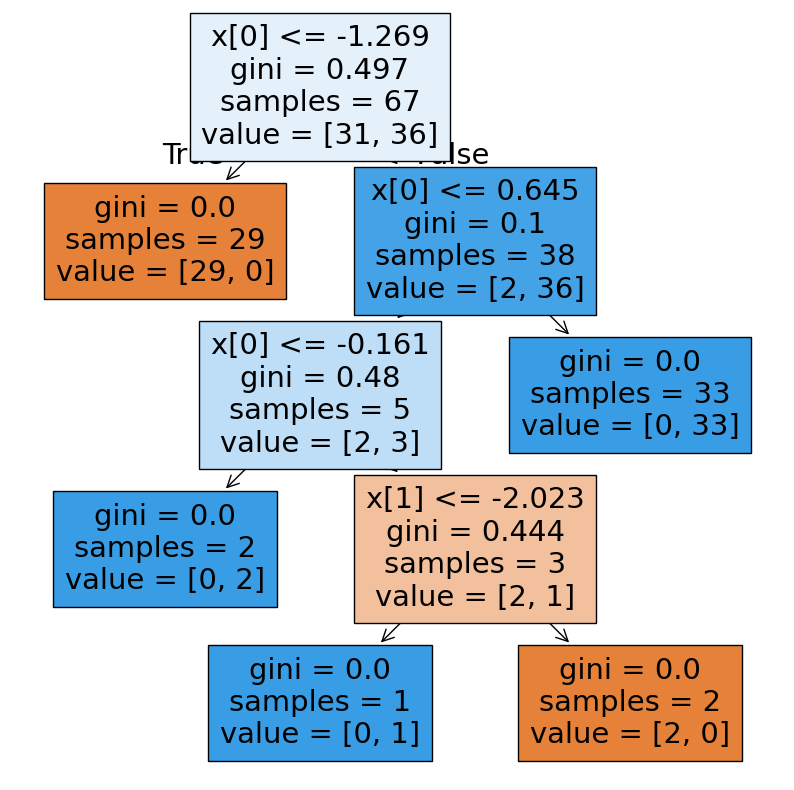

In [10]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier,plot_tree

###  TODO  ###

## C.3. Optimisation de la chaine de traitements

La construction n'est pas une fin en soi: l'idée est de pouvoir optimiser la chaine à la fois au niveau des paramètres de pré-traitements et des hyper-paramètres.

On veut tester les options suivantes (en combinaison):
* Sélection de 2 à 5 variables (avec le sélecteur simple à base de correlation)
* SVM
    * noyau linéaire
    * noyau gaussien avec `gamma = [0.1, 0.5, 1, 2, 5]`
    * compromis de régularisation : `C = [0.1,1,5,10,100]`

1. Construire la chaine de traitement
2. Utiliser le `grid_search` vu dans le TP 1 pour optimiser l'ensemble
    * Dans un premier temps, mettre tous les paramètres *en vrac* <BR>
    https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
    * Dans un second temps, essayer de ne pas calculer les combinaisons absurdes (tester toutes les valeurs de gamma pour un noyau linéaire) <BR>
    Il faut faire des sous-dictionnaires

3. Expliquer quelle chaine est retenue et à quel niveau de performances attendu

> A votre avis, êtes-vous dans dans un cadre APP/TEST ou dans un cadre APP/VAL/TEST?


In [ ]:
# Construction de la chaine (pipeline)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# V1 : test en vrac (~29 secondes sur mon ordinateur portable)
# v2 : test raisonnable (~17 secondes sur mon ordinateur portable)
# +> Comprendre pourquoi l'une des approches est plus raisonnable que l'autre

### MISE EN PLACE DE LA CHAINE ###
estimator = Correl()
selector = SequentialFeatureSelector(estimator)
classif = svm.SVC()
# liste de tuples: titre + objet 
pipe = Pipeline([('selvar',selector),('classif',classif)])

# paramètres en vrac: TITRE__para: [valeurs à tester]
# V1
grid = {
    "selvar__n_features_to_select": [2, 3, 4, 5],
    "classif__C": [0.1,1,5,10,100],
    "classif__gamma": [0.1, 0.5, 1, 2, 5],
    "classif__kernel": ["linear","rbf"],
}
#V2 avec sous-dictionnaire 
grid = [
    {"selvar__n_features_to_select": [2, 3, 4, 5],
    "classif__C": [0.1,1,5,10,100],
    "classif__kernel": ["linear"]},
    {"selvar__n_features_to_select": [2, 3, 4, 5],
    "classif__C": [0.1,1,5,10,100], "classif__gamma": [0.1, 0.5, 1, 2, 5],
    "classif__kernel": ["rbf"]}
]
# verification des combinaisons qui seront testées
# param_grid = list(ParameterGrid(grid))
print(list(ParameterGrid(grid)))

search = GridSearchCV(pipe, grid, n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


[{'classif__C': 0.1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 2}, {'classif__C': 0.1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 3}, {'classif__C': 0.1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 4}, {'classif__C': 0.1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 5}, {'classif__C': 1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 2}, {'classif__C': 1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 3}, {'classif__C': 1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 4}, {'classif__C': 1, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 5}, {'classif__C': 5, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 2}, {'classif__C': 5, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 3}, {'classif__C': 5, 'classif__kernel': 'linear', 'selvar__n_features_to_select': 4}, {'classif__C': 5, 'classif__kernel': 'linear', 'selvar__n_features_to_select':

### Optuna

Optuna vous propose des outils avancés pour régler les hyperparamètres:

1. Des outils agréables pour le grid-search
2. Passer du grid-search à une optimisation fine qui brise la combinatoire

J'ai copié les 3 étapes du tuto officiel qui me semble parfait (source: https://optuna.readthedocs.io/en/stable/)

In [16]:
# Si besoin
# ! pip install optuna

import optuna

#### 1. Se mettre dans les conditions d'un problème d'optimisation

Sans optimisation       

In [17]:
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection


def objective():
    iris = sklearn.datasets.load_iris()  # Prepare the data.

    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=5, max_depth=3)  # Define the model.

    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3
    ).mean()  # Train and evaluate the model.


print("Accuracy: {}".format(objective()))

Accuracy: 0.9466666666666667


#### 2. Une recherche plus fine pour briser la combinatoire

On laisse optuna se *balader* dans l'espace des paramètres

1. Remplacer les valeurs de vos paramètres par un générateur:
```
n_estimators = trial.suggest_int("n_estimators", 2, 20)
```
2. Lancer l'optimisation
```
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
```

In [18]:
def objective(trial):
    iris = sklearn.datasets.load_iris()

    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))

    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3
    ).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-10-06 21:46:55,947] A new study created in memory with name: no-name-0f69d1ee-862b-4f54-bd36-1d7788ffbad5
[I 2025-10-06 21:46:56,853] Trial 0 finished with value: 0.96 and parameters: {'n_estimators': 6, 'max_depth': 6.881353770888518}. Best is trial 0 with value: 0.96.
[I 2025-10-06 21:46:57,756] Trial 1 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 12, 'max_depth': 11.041208973180337}. Best is trial 0 with value: 0.96.
[I 2025-10-06 21:46:57,785] Trial 2 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 14, 'max_depth': 16.327024037692183}. Best is trial 0 with value: 0.96.
[I 2025-10-06 21:46:58,681] Trial 3 finished with value: 0.96 and parameters: {'n_estimators': 20, 'max_depth': 10.329337352001302}. Best is trial 0 with value: 0.96.
[I 2025-10-06 21:46:58,710] Trial 4 finished with value: 0.96 and parameters: {'n_estimators': 13, 'max_depth': 3.9436805433626407}. Best is trial 0 with value: 0.96.
[I 2025-10-06 21:46:59,68

Accuracy: 0.9733333333333333
Best hyperparameters: {'n_estimators': 17, 'max_depth': 3.787205585772728}


#### 3. Avec des hyper-paramètres conditionnels aux différents modèles


In [ ]:
import sklearn.svm


def objective(trial):
    iris = sklearn.datasets.load_iris()

    classifier = trial.suggest_categorical("classifier", ["RandomForest", "SVC"])

    if classifier == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 2, 20)
        max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth
        )
    else:
        c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)

        clf = sklearn.svm.SVC(C=c, gamma="auto")

    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3
    ).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

## C.4. Exercice

Mêmes opérations que précédemment, mais:

* Sur les données de qualité du vin
* avec une normalisation standard
* une random forest ou un XGBoost/catboost dont on fera varier le nombre et la profondeur des arbres


In [19]:
filename = "data/winequality-red.csv"
data = pd.read_csv(filename)
X = data.values[:,:-1]
Y = data.values[:,-1]
# remise en forme des Y entre 0 et nClasses
val = np.unique(Y)
transf = dict(zip(val,np.arange(len(val)))) # mapping [x,y,z] => [0,1,2]
y = np.vectorize(transf.get)(Y)             # application de la transformation


In [ ]:
# TODO

## C.5. Chaine de traitement et enrichissement des données

Mêmes opérations que précédemment, mais en ajoutant des dimensions.

La difficulté est de trouver l'objet scikit-learn qui permet d'insérer des colonnes dans les données

* La chaine transformera les variables en catégories (one-hot) 
* Appliquera une régression logistique

Le but est ensuite de chercher à optimiser une chaine de traitement contenant de l'enrichissement de données (par exemple, tester différentes valeurs pour la discrétisation)



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

features_id = [3]
scale_id = [1,2]

preprocessor = ColumnTransformer(
    [
        ("untouched", StandardScaler(), scale_id ), # np.setdiff1d(np.arange(X.shape[1]), features_id)),
        (
            "tobin",
            KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='uniform'),
            features_id,
        ),
    ],
)

#print(np.setdiff1d(np.arange(X.shape[1]), features_id))
# print(preprocessor.fit_transform(X).toarray())
print(X.shape)

log_reg = make_pipeline(preprocessor, LogisticRegression())
log_reg.fit(X, y)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
numeric_features = ["age", "fare"]
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_features = ["embarked", "pclass"]

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    verbose_feature_names_out=False,
)
log_reg = make_pipeline(preprocessor, SelectKBest(k=7), LogisticRegression())
#log_reg.fit(X, y)

sc = cross_val_score(log_reg, X, y)
print(sc)

# Construction du sujet à partir de la correction

In [ ]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###